In [218]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint
import pandas as pd
import itertools
from scipy.interpolate import interp1d

Problem 1: Gillespie’s Direct Algorithm and Stochastic Hallmarks
You will investigate the five hallmarks of stochastic SIR dynamics using an event drive
SIR model:
1. variability;
2. negative co-variances;
3. increased transients;
4. stochastic resonance;
5. extinctions.


In [219]:
def sir(variables, t, beta, gamma):
    S = variables[0]
    I = variables[1]
    R = variables[2]

    N = S + I + R

    dSdt = -beta * I * S / N
    dIdt = beta * I * S / N - gamma * I
    dRdt = gamma * I

    return([dSdt, dIdt, dRdt])

Implement Gillespies algorithm
Write some python code to implement Gillespies Algorithm (GA)
1. You should define the
events and the rates of each event for the SIR model. Keep in mind it may be insightful
to compare the GA stochastic simulation with an equivalent deterministic ODE model.

In [220]:
# Gillespies algorithm
def Gillespies(S, I, R, t, tend, beta, gamma, noise_controller=1):
    run_count = 0
    while t[-1] < tend and (S[-1] + I[-1] >= 1):
        # Get Population
        N = S[-1] + I[-1] + R[-1]

        # Get the probablities: [S -> I, I -> R]
        props = [beta*I[-1]*S[-1]/N, gamma*I[-1]]

        # Get sum of probability
        prop_sum = sum(props)

        try:       
            # Determine the time until the next event occurs based on the probabilty sum.
            tau = np.random.exponential(scale=1/prop_sum)
            t.append(t[-1]+tau) 

            # Generate random number    
            rand = random.uniform(0,1)

            # See if Susceptible becomes Infected
            if rand * prop_sum <= (props[0] * noise_controller):
                    S.append(S[-1] - 1)
                    I.append(I[-1] + 1)
                    R.append(R[-1])

            # Else, Infected becomes Recovered
            else:
                    S.append(S[-1])
                    I.append(I[-1] - 1)
                    R.append(R[-1] + 1)
                    
        except ZeroDivisionError:
                print(f"ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count{run_count}")
                run_count += 1
                if run_count> 10: 
                       print("Stochastic extinction is happening to often, choose different parameters")
                       break

    return np.array(S), np.array(I), np.array(R)
        

In [221]:
# Initial conditions
S_init = [200]
I_init = [1]
R_init = [0]
t = [0]

# Parameters
beta = 0.04
gamma = 0.01
tend = 500

In [222]:
n_runs = 10000
results = []

for i in range(n_runs):
    S, I, R = Gillespies(S_init, I_init, R_init, t, tend, beta, gamma)
    results.append((np.array(S), np.array(I), np.array(R)))

mean_S = np.mean([result[0] for result in results], axis=0)
mean_I = np.mean([result[1] for result in results], axis=0)
mean_R = np.mean([result[2] for result in results], axis=0)

In [223]:
def RMSE(x, y):
    if not len(x) == len(y):
        raise ValueError("x and y must be of same length")
    return np.sqrt(np.mean(np.square(x - y)))

In [224]:
y0 = [200, 1, 0]
y = odeint(sir, y0, t, args=(beta, gamma))

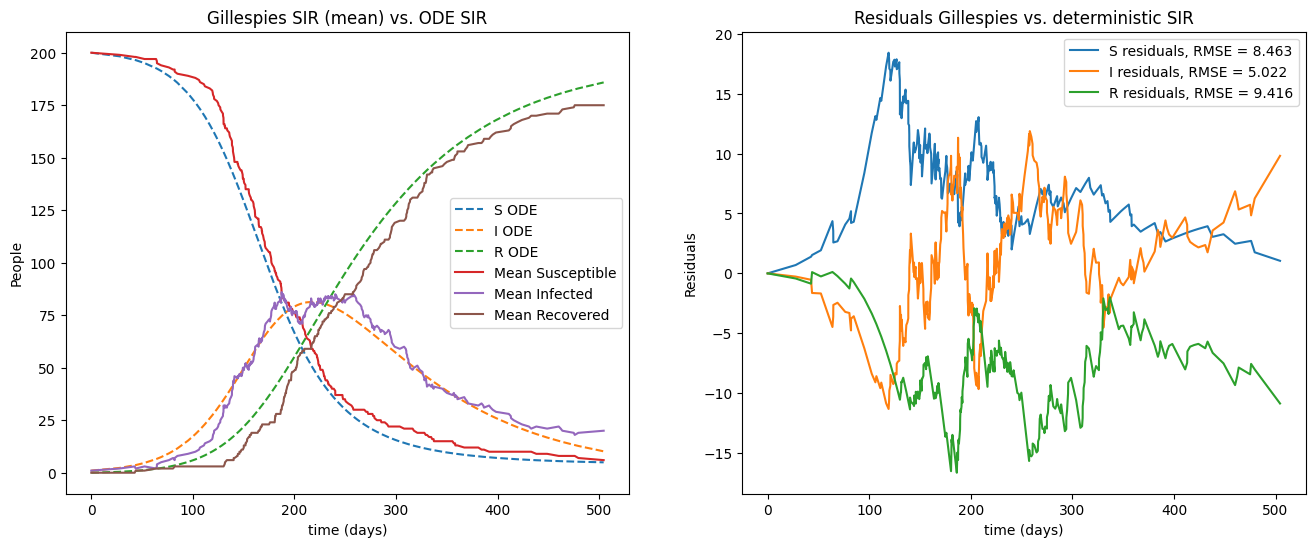

In [227]:
# plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(t,y[:,0], label = "S ODE", ls='--') # S
ax1.plot(t,y[:,1], label = "I ODE", ls='--') # I
ax1.plot(t,y[:,2], label = "R ODE", ls='--') # R
ax1.plot(t, mean_S, label='Mean Susceptible')
ax1.plot(t, mean_I, label='Mean Infected')
ax1.plot(t, mean_R, label='Mean Recovered')
ax1.set_xlabel('time (days)')
ax1.set_ylabel('People')
ax1.legend()
ax1.set_title('Gillespies SIR (mean) vs. ODE SIR')


ax2.plot(t, np.subtract(mean_S, y[:,0]), label = f'S residuals, RMSE = {round(RMSE(mean_S, y[:,0]),3)}')
ax2.plot(t, np.subtract(mean_I, y[:,1]), label = f'I residuals, RMSE = {round(RMSE(mean_I, y[:,1]),3)}')
ax2.plot(t, np.subtract(mean_R, y[:,2]), label = f'R residuals, RMSE = {round(RMSE(mean_R, y[:,2]),3)}')
ax2.set_xlabel('time (days)')
ax2.set_ylabel('Residuals')
ax2.legend()
ax2.set_title('Residuals Gillespies vs. deterministic SIR')

fig.savefig('Residuals Gillespies vs. deterministic SIR.png')

BONUS: You can also think about (and implement) a way to control the noise level in
the GA.

In [230]:
n_runs = 10000
noise_control = np.arange(0.8, 1.3, 0.1)

for noise in noise_control:
    results = []
    for i in range(n_runs):
        S, I, R = Gillespies(S_init, I_init, R_init, t, tend, beta, gamma, noise_controller=noise)
        results.append((np.array(S), np.array(I), np.array(R)))

    mean_S = np.mean([result[0] for result in results], axis=0)
    mean_I = np.mean([result[1] for result in results], axis=0)
    mean_R = np.mean([result[2] for result in results], axis=0)